# Indicador compuesto adelantado para la economía española

Con este notebook vamos a reproducir un indicador compuesto aledantado de la economía española publicado [aquí](http://uam-ucm-economic-indicators.es/).

<div id="toc"></div>

Para el filtrado (filtro de Kalman y suavizado de intervalo fijo) usaremos la toolbok [E4](https://www.ucm.es/e-4/), para ello es necesario ejecutar lo siguiente:

In [1]:
e4init
figure(1); close(1) # en mi PC me da error al generar las figuras png embedidas en el notebook si no hago esto.


            XXXXXX 4 4      XXXXX  XX     XX  XX  XXXXXX (c)
           XX      444     XX  XX XX     XX  XX  XX
          XXXX       4    XXXXX  XX     XX  XX  XXXXXX
         XX              XX     XX     XX  XX      XX
        XXXXXX          XX     XXXXXX XXXXXX  XXXXXX

    Toolbox for State Space Estimation of Econometric Models
 
*********************** Options set by user ********************
Filter. . . . . . . . . . . . . : KALMAN
Scaled B and M matrices . . . . : NO
Initial state vector. . . . . . : AUTOMATIC SELECTION
Initial covariance of state v.  : IDEJONG
Variance or Cholesky factor?  . : VARIANCE
Optimization algorithm. . . . . : BFGS
Maximum step length . . . . . . : 0.100000
Stop tolerance. . . . . . . . . : 0.000010
Max. number of iterations . . . :       75
Verbose iterations. . . . . . . : YES
****************************************************************
 
 


Tambien es necesario cargar el toolbox de control

In [2]:
pkg load control

Creo un diccionario (struct) de diccionarios con los nombres códigos y etiquetas de los cuatro indicadores del Indicador Adelantado

In [3]:
s = struct ("nombre",   {"casas",   "cemento", "turismos", "vcarga"},
            "codigo",   {"230410g", "236000" , "271200"  , "282100"},
            "etiqueta", {"NUMERO VIVIENDAS OBRA NUEVA","CONSUMO APARENTE DE CEMENTO","MATRICULACIONES DE TURISMOS","MATRICULACION DE VEHICULOS DE CARGA"});

Cargo las series en memoria 
* la primera columna tiene fechas y la segunda los datos originales 
* el nombre que asigna octave añade una "X" delante del código de cada variable).

Guardo los datos en logaritmos de cada serie 
* cada una con su "nombre"

Las pinto 
* incluyendo la correspondiente "etiqueta"

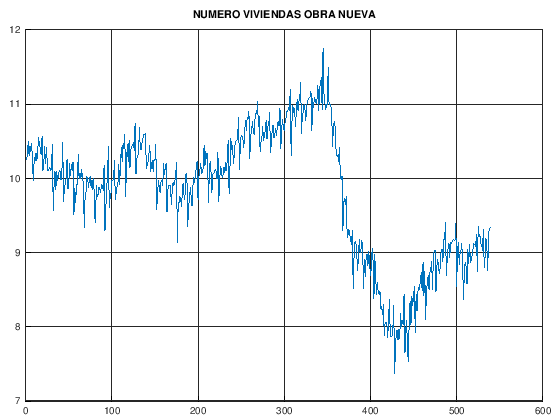

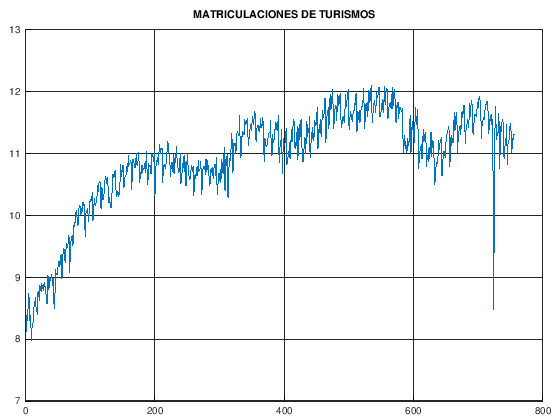

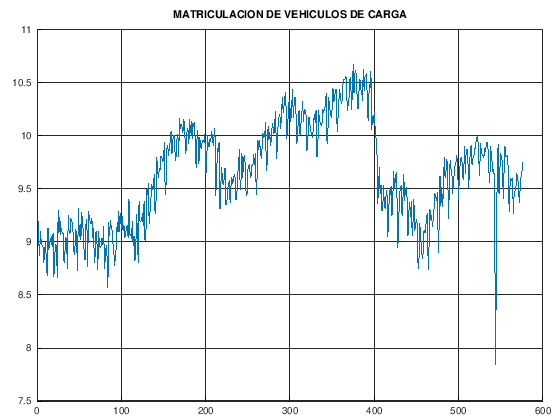

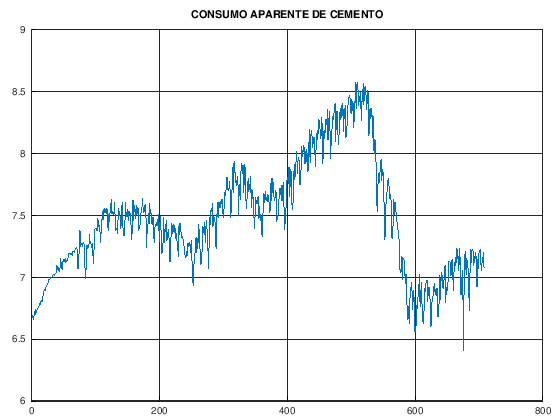

In [4]:
%plot --format png
for i = 1:size(s,2)
    eval(sprintf("load %s",strcat("data/dataFECHAS/", s(i).("codigo"), ".dat")))
    eval(sprintf("%s=log(%s(:,2));", s(i).("nombre"), strcat("X",s(i).("codigo"))))
    figure(i)
    grid on
    hold on
    title(s(i).("etiqueta"))
    eval(sprintf("plot(%s)",s(i).("nombre")))
end

Primera y última fecha comunes

In [5]:
inicio=[];
final=[];
for i = 1:size(s,2)
    inicio(i)=eval(strcat("X",s(i).("codigo"),"(1,1)"));
    final (i)=eval(strcat("X",s(i).("codigo"),"(end,1)"));
end
inicio=max(inicio)
final =min(final)

inicio = 197801
final = 202211


Truncamos las series para tener una muestra con fechas comunes

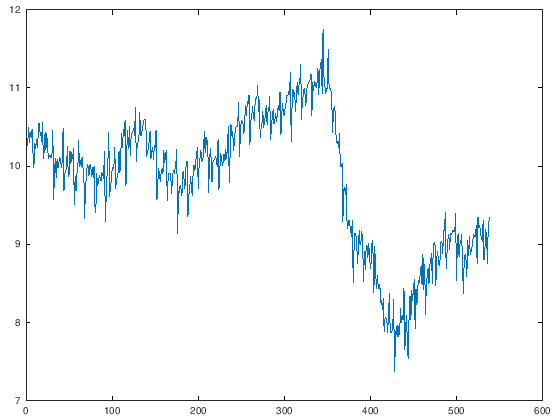

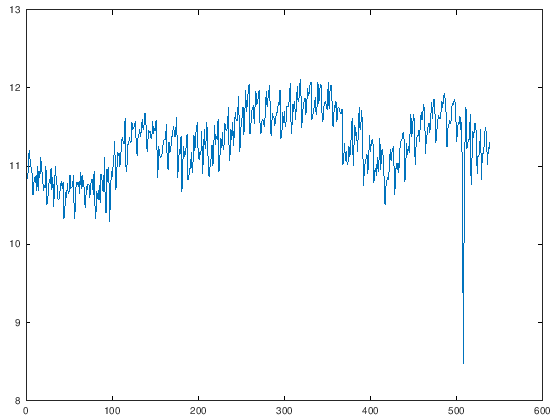

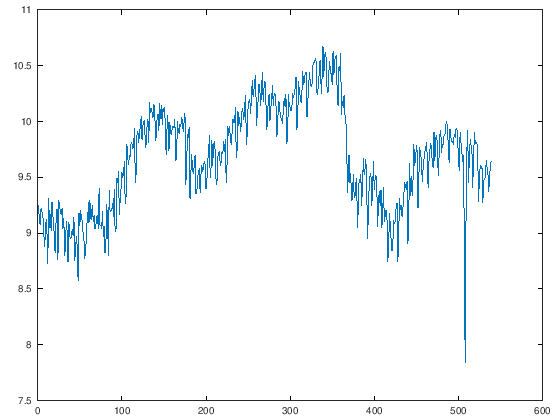

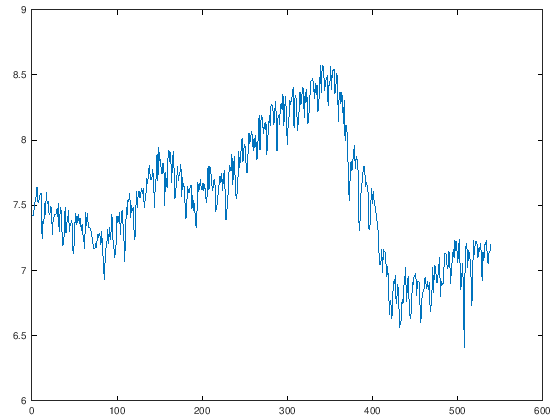

In [6]:
for i = 1:size(s,2)
    ini=find(eval(strcat("X",s(i).("codigo"),"(:,1)"))==inicio);
    fin=find(eval(strcat("X",s(i).("codigo"),"(:,1)"))==final);
    eval(sprintf("%s=%s(ini:fin);", s(i).("nombre"), s(i).("nombre")))
    figure(i)
    eval(sprintf("plot(%s)", s(i).("nombre")))
end

En `PaP` guadaremos un vector con los periodos correspondientes a la estacionalidad para datos mensuales:

In [7]:
PaP=12./(0:6)

PaP =

       Inf   12.0000    6.0000    4.0000    3.0000    2.4000    2.0000



En `TVPaP` guardamos el modelo por defecto IRW para la tendencia y RW los componentes DHR estacionales

In [8]:
TVPaP=[1 1 1 1 1 1 1;1 0 0 0 0 0 0]

TVPaP =

   1   1   1   1   1   1   1
   1   0   0   0   0   0   0



## El análisis de cada serie lo haremos por separado
### Casas
Vamos a forzar el modelo por defecto añadiendo un `1` tras el argumento `TVPaP` (si no lo ponemos, identifica una tendencia SRW, que irá cambiando con las distintas muestras... si se estima el modelo con distintas muestras).

In [9]:
[VAR,P,TVP,oar]=autodhr(casas,12,[],[],PaP,TVPaP,1) 

VAR =

 Columns 1 through 6:

   1.2017e-02   4.9255e-05   6.9629e-05   2.9554e-05   2.8847e-05   1.0932e-04

 Columns 7 and 8:

   1.9014e-05   2.4871e-05

P =

       Inf   12.0000    6.0000    4.0000    3.0000    2.4000    2.0000

TVP =

   1   1   1   1   1   1   1
   1   0   0   0   0   0   0

oar = 27


Podemos calcular los ratios de varianzas (NVR) del siguiente modo:

In [10]:
NVR=VAR(2:8)./VAR(1)

NVR =

 Columns 1 through 6:

   4.0989e-03   5.7944e-03   2.4595e-03   2.4006e-03   9.0971e-03   1.5824e-03

 Column 7:

   2.0697e-03



Vamos a filtrar los componentes con el modelo identificado

In [11]:
filt=0;  # la modalidad 0 usa e4trend con el suavizado de intervalo fijo
[casasTrend,season,cycle,irreg]=dhrfilt(casas,P,TVP,VAR,12,filt,0);

Visualicemos los componentes de tendencia y el irregular

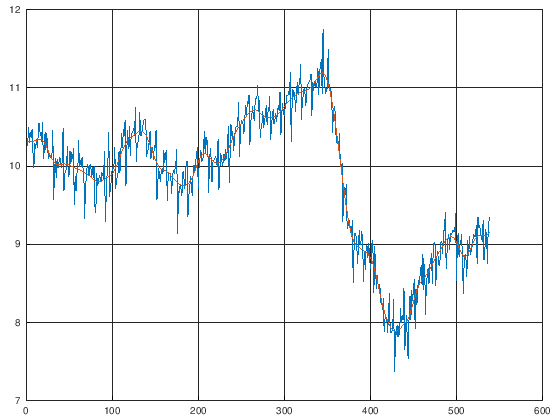

In [12]:
grid on
hold on
plot([casas,casasTrend(:,1)])

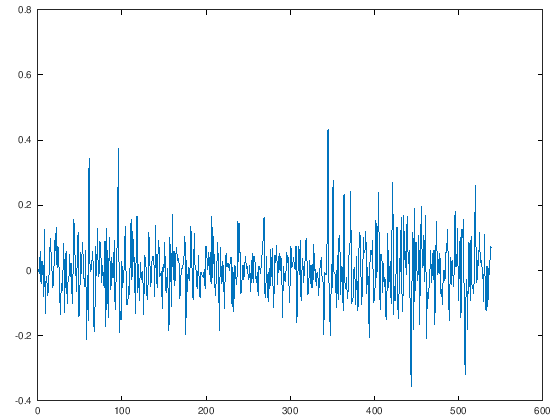

In [13]:
plot([irreg])

repetimos los mismos pasos con el resto de indicadores

### Cemento

In [14]:
[VAR,P,TVP,oar]=autodhr(cemento,12,[],[],PaP,TVPaP,1) 
NVR=VAR(2:8)./VAR(1)
[cementoTrend,season,cycle,irreg]=dhrfilt(cemento,P,TVP,VAR,12,filt,0);

VAR =

 Columns 1 through 6:

   2.1528e-03   6.8025e-06   2.3373e-05   1.7306e-05   8.8479e-06   3.5822e-05

 Columns 7 and 8:

   1.2386e-05   4.0697e-06

P =

       Inf   12.0000    6.0000    4.0000    3.0000    2.4000    2.0000

TVP =

   1   1   1   1   1   1   1
   1   0   0   0   0   0   0

oar = 35
NVR =

 Columns 1 through 6:

   3.1598e-03   1.0857e-02   8.0387e-03   4.1099e-03   1.6639e-02   5.7532e-03

 Column 7:

   1.8904e-03



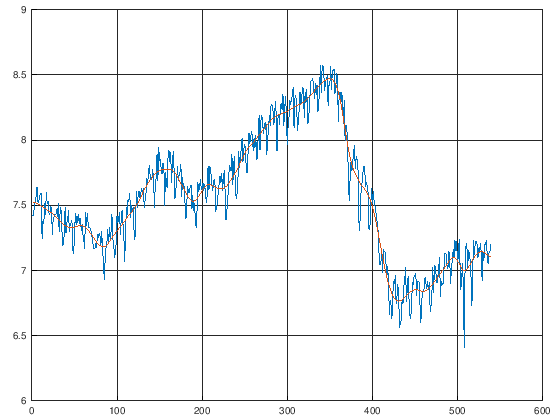

In [15]:
grid on
hold on
plot([cemento,cementoTrend(:,1)])

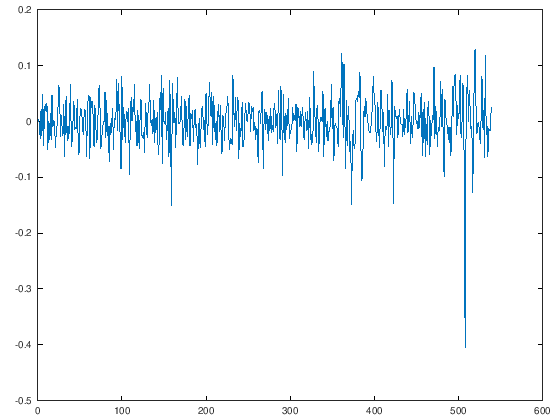

In [16]:
plot(irreg)

### Turismos

In [17]:
[VAR,P,TVP,oar]=autodhr(turismos,12,[],[24:45],PaP,TVPaP,1) 
NVR=VAR(2:8)./VAR(1)
[turismosTrend,season,cycle,irreg]=dhrfilt(turismos,P,TVP,VAR,12,filt,0);

VAR =

 Columns 1 through 6:

   1.1992e-02   5.7688e-06   6.3981e-05   3.3292e-05   2.5029e-06   3.8041e-05

 Columns 7 and 8:

   3.7909e-06   8.5968e-07

P =

       Inf   12.0000    6.0000    4.0000    3.0000    2.4000    2.0000

TVP =

   1   1   1   1   1   1   1
   1   0   0   0   0   0   0

oar = 43
NVR =

 Columns 1 through 6:

   4.8107e-04   5.3355e-03   2.7763e-03   2.0872e-04   3.1723e-03   3.1613e-04

 Column 7:

   7.1690e-05



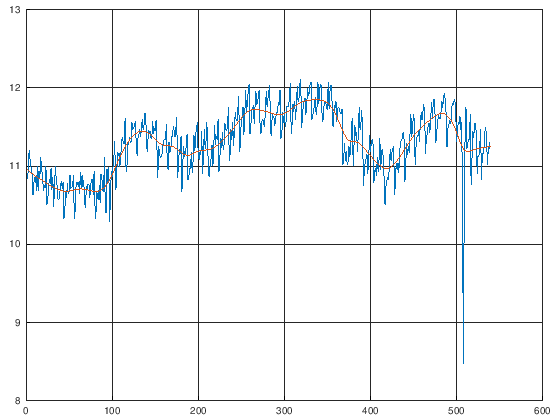

In [18]:
grid on
hold on
plot([turismos,turismosTrend(:,1)])

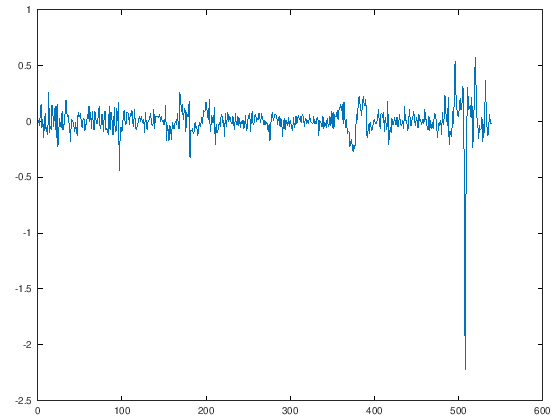

In [19]:
plot(irreg)

### Vehículos de carga

In [20]:
[VAR,P,TVP,oar]=autodhr(vcarga,12,[],[24:45],PaP,TVPaP,1) 
NVR=VAR(2:8)./VAR(1)
[vcargaTrend,season,cycle,irreg]=dhrfilt(vcarga,P,TVP,VAR,12,filt,0);

VAR =

 Columns 1 through 6:

   6.4684e-03   2.2732e-05   4.0634e-05   9.2899e-06   1.0557e-05   2.1220e-05

 Columns 7 and 8:

   5.9691e-06   1.4676e-06

P =

       Inf   12.0000    6.0000    4.0000    3.0000    2.4000    2.0000

TVP =

   1   1   1   1   1   1   1
   1   0   0   0   0   0   0

oar = 41
NVR =

 Columns 1 through 6:

   3.5144e-03   6.2820e-03   1.4362e-03   1.6321e-03   3.2805e-03   9.2281e-04

 Column 7:

   2.2690e-04



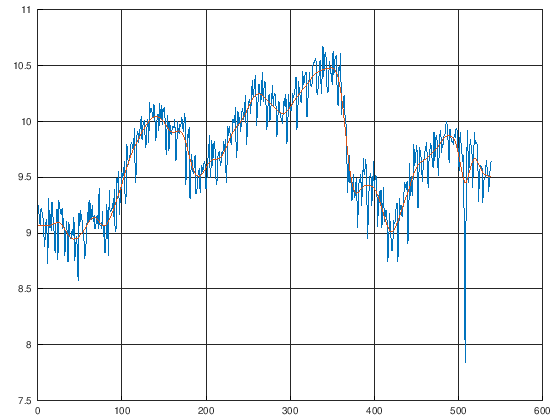

In [21]:
grid on
hold on
plot([vcarga,vcargaTrend(:,1)])

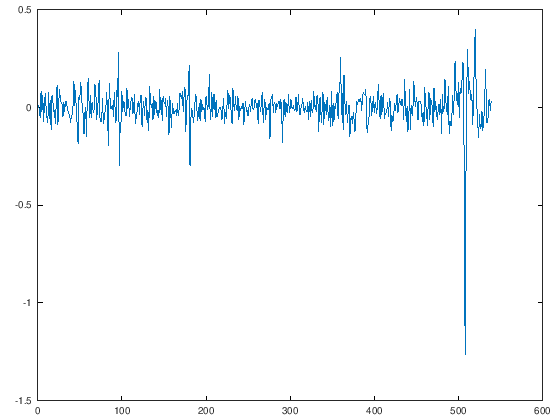

In [22]:
plot(irreg)

## Creación del indicador compuesto

In [23]:
k = 5; # retardo
b = [casasTrend(:,1),cementoTrend(:,1),turismosTrend(:,1),vcargaTrend(:,1)]';
#b = b(:,1:300);
B = b*(eye(length(b))-ones(length (b))/length(b));
[V, LAMBDA] = eig( B(:,1:length(b)-k)*B(:,k+1:length(b))'/(length(b)^(1)) )

V =

   0.830811   0.436330   0.338729  -0.133100
   0.417237  -0.119438  -0.879330   0.083392
   0.183440  -0.631450   0.130982  -0.740067
   0.319400  -0.629779   0.308035   0.653935

LAMBDA =

Diagonal Matrix

   9.7486e-01            0            0            0
            0   2.0205e-01            0            0
            0            0   3.3575e-02            0
            0            0            0   5.0397e-03



In [24]:
[m,ix]  = max(diag(LAMBDA ));
Weights = V(:,ix)./sum(V(:,ix))

Weights =

   0.4745
   0.2383
   0.1048
   0.1824



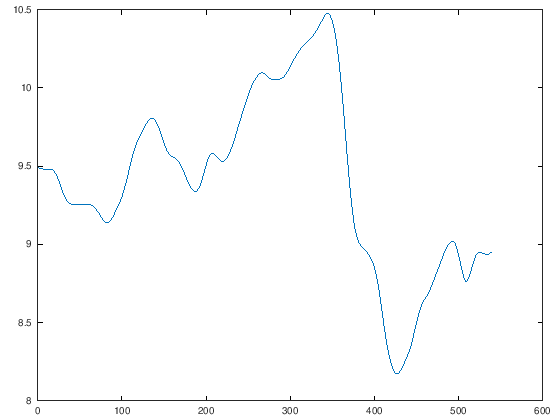

In [25]:
CI=b'*Weights;
plot(CI)

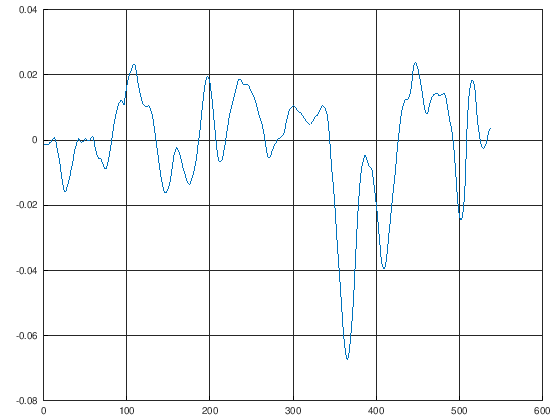

In [26]:
grid on
hold on
plot(diff(CI))

In [27]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>